In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import arviz as az
from cycler import cycler

from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive


CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)

In [2]:
PLOTS_DIR = os.path.join("..", "plots")
raw = pd.read_csv("../data/raw/hyper_challenge.csv")
prepped = load_prepared_data("../data/prepared/hypertension.json")

In [3]:
msts = prepped.measurements
msts.head()

,age,treatment,mouse,vessel_type,corr_bp_diam,atanh_corr_bp_diam
168,adult,hyper1,11020,bulb,0.900308,1.473841
152,adult,hyper1,110321,bulb,-0.336590,-0.350242
192,adult,hyper1,121020,bulb,0.244380,0.249427
194,adult,hyper1,140920,bulb,0.372125,0.390887
148,adult,hyper1,160321,bulb,0.833789,1.200440


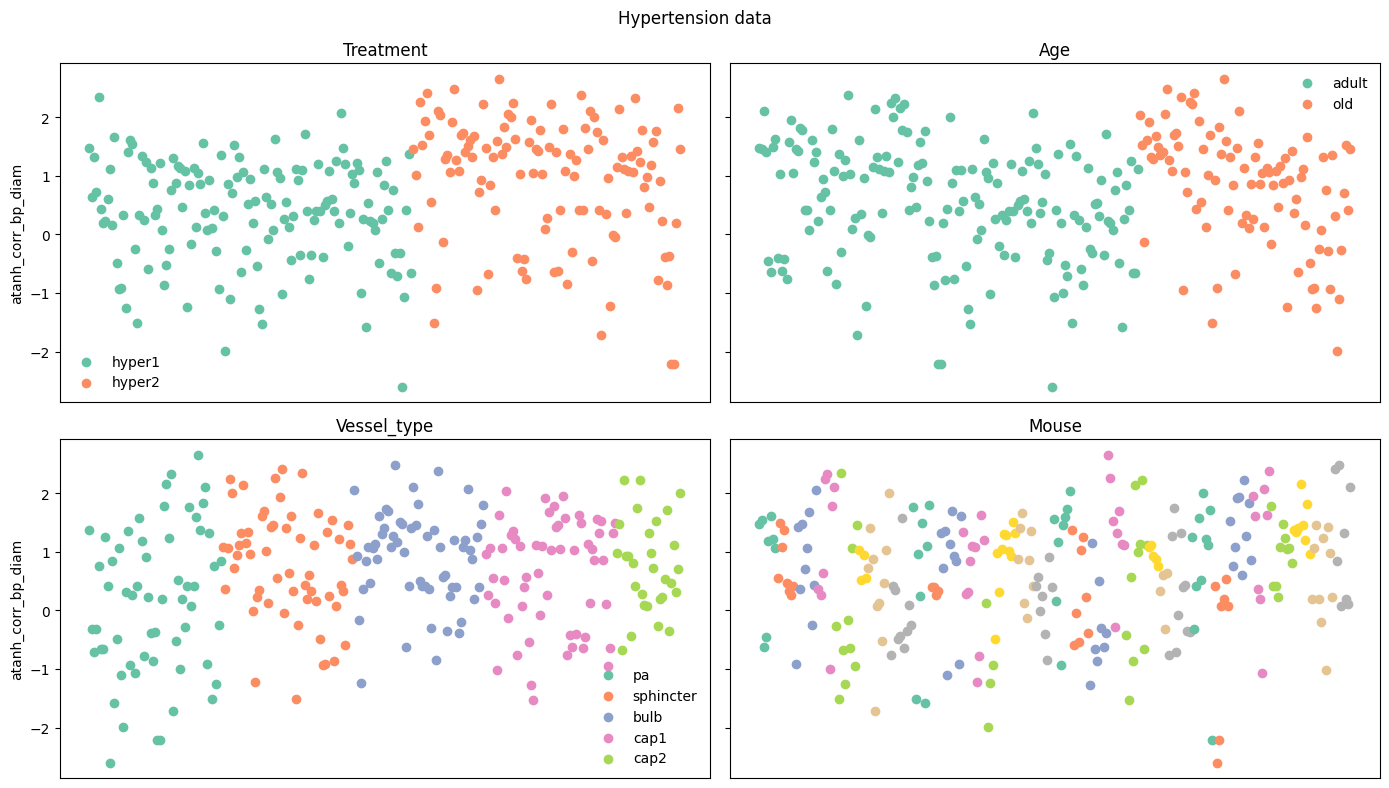

In [4]:
ycol = "atanh_corr_bp_diam"

f, axes = plt.subplots(2, 2, figsize=[14, 8], sharey=True)
axes = axes.ravel()
for (i, ax), col in zip(enumerate(axes), ["treatment", "age", "vessel_type", "mouse"]):
    sct = plot_obs(ax, msts[ycol], cat=msts[col])
    if col != "mouse":
        ax.legend(frameon=False);
    if i % 2 == 0:
        ax.set_ylabel(ycol);
    ax.set_xticks([])
    ax.set_title(col.capitalize())
f.suptitle("Hypertension data");
f.tight_layout()
f.savefig(os.path.join(PLOTS_DIR, "hypertension-data.png"), bbox_inches="tight")

In [5]:
idatas = {
    dirname: az.InferenceData.from_zarr(os.path.join("..", "inferences", dirname, "idata"))
    for dirname in ["hypertension-big", "hypertension-basic"]
}
for idata_name, idata in idatas.items():
    print(idata_name + ":")
    display(az.summary(idata.sample_stats))

hypertension-big:


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.989,0.016,0.961,1.000,0.001,0.001,107.0,3047.0,1.04
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-45.922,5.661,-56.358,-35.250,0.170,0.120,1108.0,1865.0,1.00
lp,58.939,4.253,51.029,66.742,0.126,0.089,1144.0,2112.0,1.00
n_steps,151.644,55.229,127.000,255.000,22.225,16.524,7.0,6.0,1.62
step_size,0.030,0.006,0.021,0.036,0.003,0.002,4.0,4.0,inf
tree_depth,7.095,0.451,7.000,8.000,0.152,0.114,9.0,198.0,1.35


hypertension-basic:


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
acceptance_rate,0.986,0.019,0.952,1.000,0.001,0.001,387.0,3813.0,1.02
diverging,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN
energy,-58.468,4.373,-66.137,-49.882,0.127,0.090,1199.0,1909.0,1.01
lp,67.147,3.241,60.969,72.682,0.103,0.073,1001.0,1889.0,1.01
n_steps,412.042,396.695,63.000,1023.000,7.096,5.018,2543.0,71.0,1.01
step_size,0.044,0.007,0.033,0.051,0.004,0.003,4.0,4.0,inf
tree_depth,7.643,1.593,6.000,10.000,0.030,0.021,480.0,38.0,1.02


arviz - WARNING - Array contains NaN-value.
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (
/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:307: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'log' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_comp.loc[val] = (


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
hypertension-basic,0,-168.848384,11.123356,0.000000,1.0,11.562998,0.00000,False,log
hypertension-big,1,-169.660507,12.109554,0.812123,0.0,11.541009,0.31718,False,log


/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


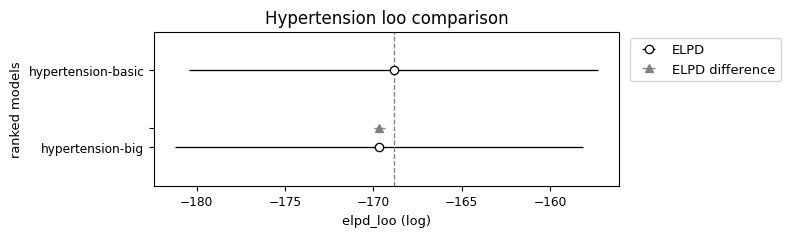

In [6]:
comp = az.compare(idatas)

display(comp)

f, ax = plt.subplots(figsize=[6, 2])
az.plot_compare(comp, ax=ax)
ax.set(title="Hypertension loo comparison")
f.savefig(os.path.join(PLOTS_DIR, "hypertension-loo.png"), bbox_inches="tight")

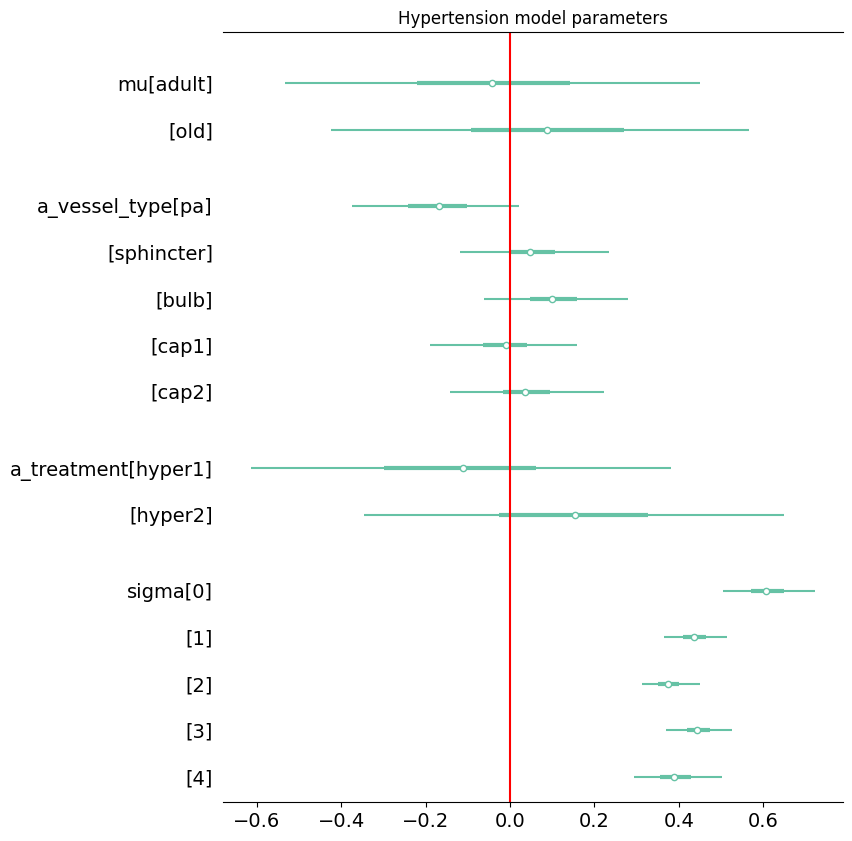

In [7]:
vars = ["mu", "a_vessel_type", "a_treatment", "sigma"]
f, ax = plt.subplots(figsize=[8, 10], sharex=True)
az.plot_forest(
    idatas["hypertension-basic"],
    ax=ax,
    combined=True,
    var_names=vars,
);
ax.set(title="Hypertension model parameters")
ax.axvline(0, color="red");

f.savefig(os.path.join(PLOTS_DIR, "hypertension-parameters.png"), bbox_inches="tight")

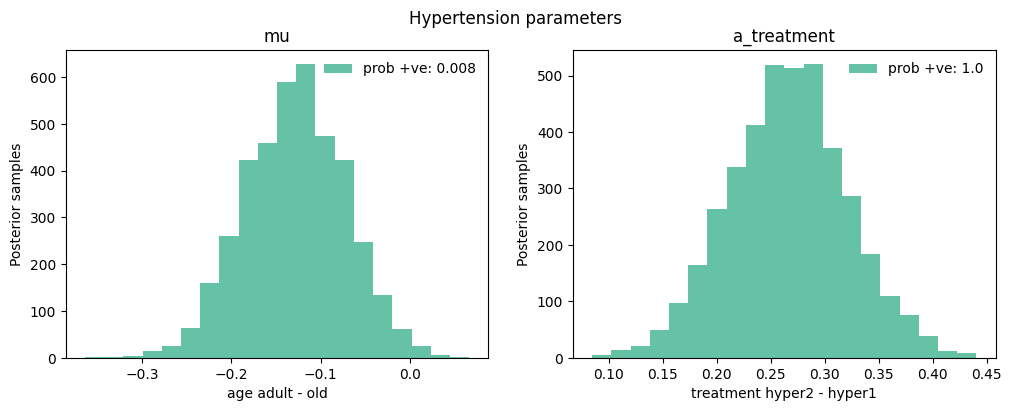

In [8]:
f, axes = plt.subplots(1, 2, figsize=[12, 4])
axes = axes.ravel()

for ax, param_name, coord, (a, b) in zip(
    axes,
    ["mu", "a_treatment"], 
    ["age", "treatment"],
    [("adult", "old"), ("hyper2", "hyper1")]
):
    t = idata.posterior[param_name].sel({coord: a}) - idata.posterior[param_name].sel({coord: b})
    pr = str(round((t > 0).mean().values[()], 3))
    ax.hist(t.values.flatten(), bins=20, label=f"prob +ve: {pr}");
    ax.set(title=param_name, ylabel="Posterior samples", xlabel=f"{coord} {a} - {b}")
    ax.legend(frameon=False)
f.suptitle("Hypertension parameters")
f.savefig(os.path.join(PLOTS_DIR, "hypertension-age-and-treatment.png"), bbox_inches="tight")

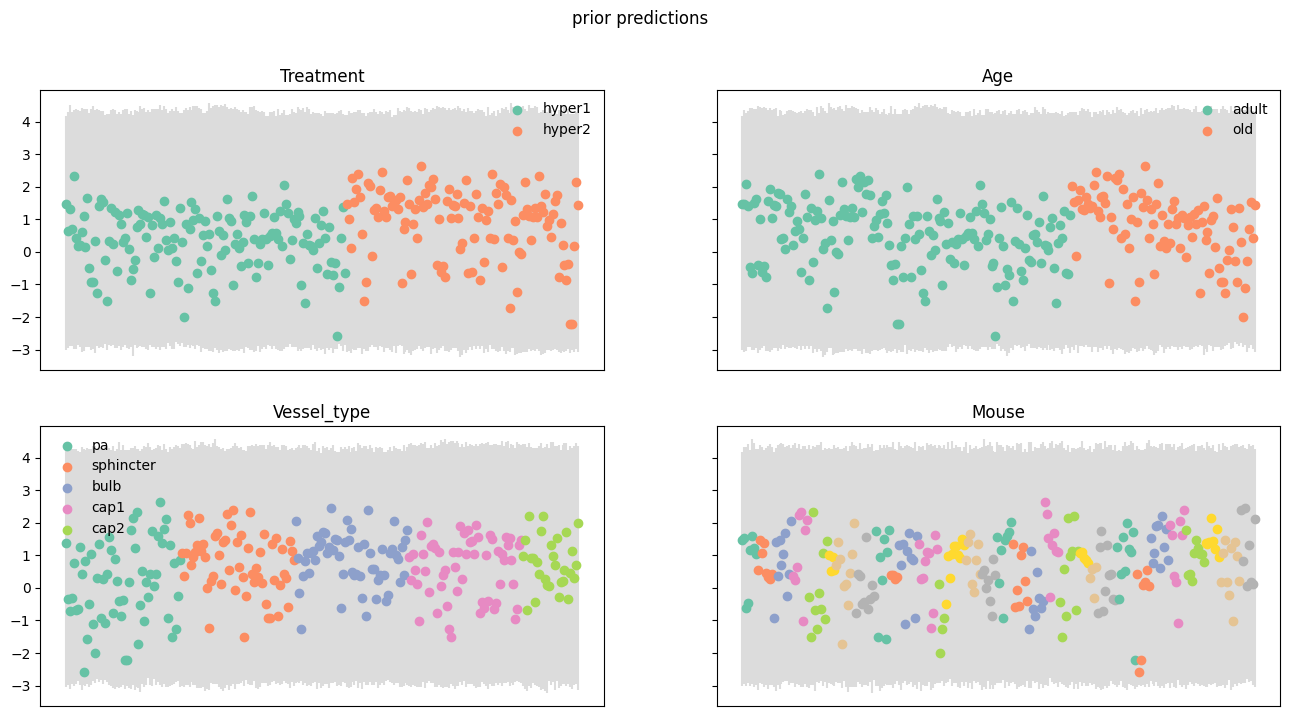

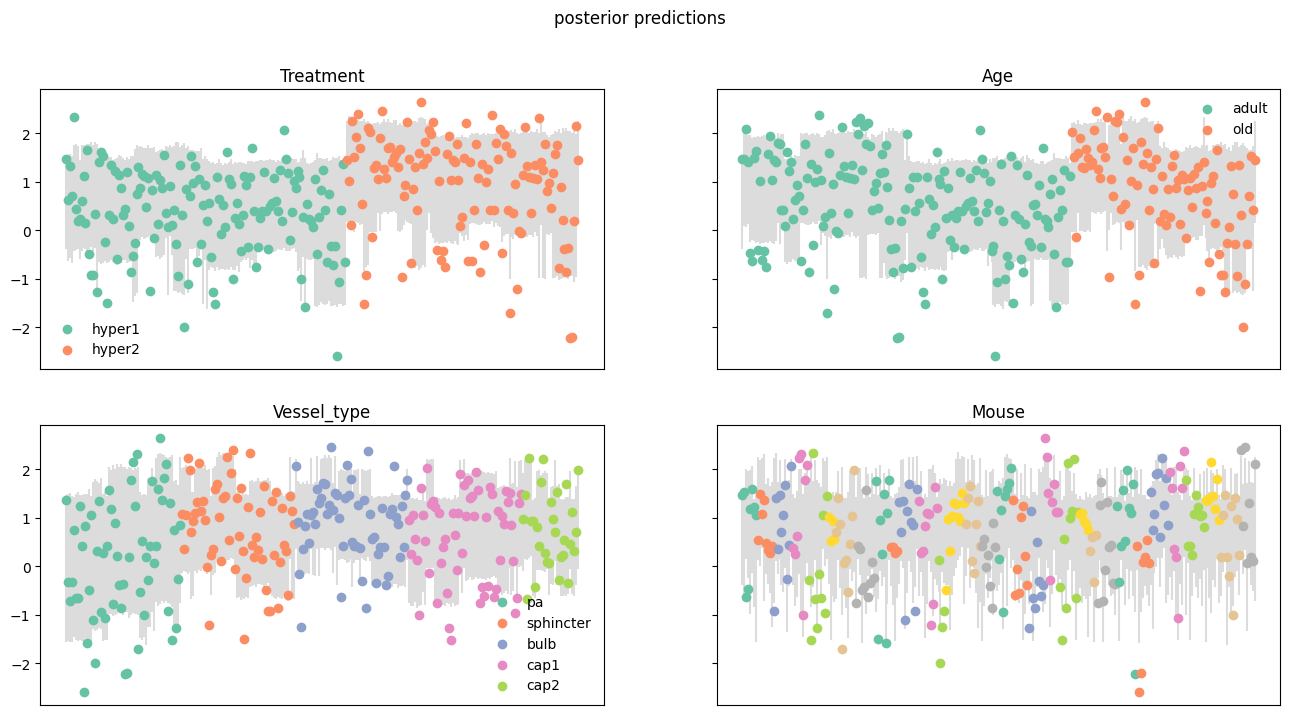

In [9]:
ycol = "atanh_corr_bp_diam"

for group, mode in zip(
    [idata.prior_predictive, idata.posterior_predictive], ["prior", "posterior"]
):
    yrep = group["yrep"]
    obs = msts[ycol]
    f, axes = plt.subplots(2, 2, figsize=[16, 8], sharey=True)
    axes = axes.ravel()
    for ax, col in zip(axes, ["treatment", "age", "vessel_type", "mouse"]):
        obs = plot_obs(ax, msts[ycol], cat=msts[col])
        lines = plot_predictive(ax, yrep, cat=msts[col], zorder=-1)
        if col != "mouse":
            ax.legend(frameon=False)
        ax.set_xticks([])
        ax.set(title=col.capitalize())
    f.suptitle(f"{mode} predictions")
    f.savefig(
        os.path.join(PLOTS_DIR, f"hypertension-{mode}-predictive.png"), 
        bbox_inches="tight"
    )